**self_boosted_time_series_forecasting**

In [10]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [11]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [12]:
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import datetime
from tqdm.notebook import tqdm
%load_ext tensorboard
print(tf.version.VERSION)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.2.0


In [13]:
df = pd.read_csv('/content/drive/My Drive/Assignment_FinGenesis/MD from 2010 to 2020/EURUSD.csv', usecols=[0,1,2,3,4])
# Sort DataFrame by date
df = df.sort_values('Time (UTC)')
df['Time (UTC)'] = pd.to_datetime(df['Time (UTC)'])
df.head()


,Time (UTC),Open,High,Low,Close
0,2010-01-01 02:00:00,1.43295,1.43317,1.43188,1.43311
1,2010-01-01 06:00:00,1.43293,1.43353,1.43226,1.43331
2,2010-01-01 10:00:00,1.43328,1.43360,1.43213,1.43341
3,2010-01-01 14:00:00,1.43285,1.43368,1.43235,1.43296
4,2010-01-01 18:00:00,1.43297,1.43366,1.43251,1.43345


In [14]:
# d = pd.to_datetime(df['Time (UTC)'], format='%Y.%m.%d %H:%M:%S.%f')
#df['Time (UTC)'] = df['Time (UTC)'].astype('datetime64').astype(int).astype(float)
# df['Date'] = d.dt.date
# df['Time'] = d.dt.time

# df = df.drop(columns='Time (UTC)',axis=0)

# Double check the result
df.head()

,Time (UTC),Open,High,Low,Close
0,2010-01-01 02:00:00,1.43295,1.43317,1.43188,1.43311
1,2010-01-01 06:00:00,1.43293,1.43353,1.43226,1.43331
2,2010-01-01 10:00:00,1.43328,1.43360,1.43213,1.43341
3,2010-01-01 14:00:00,1.43285,1.43368,1.43235,1.43296
4,2010-01-01 18:00:00,1.43297,1.43366,1.43251,1.43345


In [15]:
high_prices = df.loc[:,'High']
low_prices = df.loc[:,'Low']
mid_prices = (high_prices+low_prices)/2.0
df.insert(4,'mid_price', mid_prices, True)
# Double check the result
df.head()

,Time (UTC),Open,High,Low,mid_price,Close
0,2010-01-01 02:00:00,1.43295,1.43317,1.43188,1.432525,1.43311
1,2010-01-01 06:00:00,1.43293,1.43353,1.43226,1.432895,1.43331
2,2010-01-01 10:00:00,1.43328,1.43360,1.43213,1.432865,1.43341
3,2010-01-01 14:00:00,1.43285,1.43368,1.43235,1.433015,1.43296
4,2010-01-01 18:00:00,1.43297,1.43366,1.43251,1.433085,1.43345


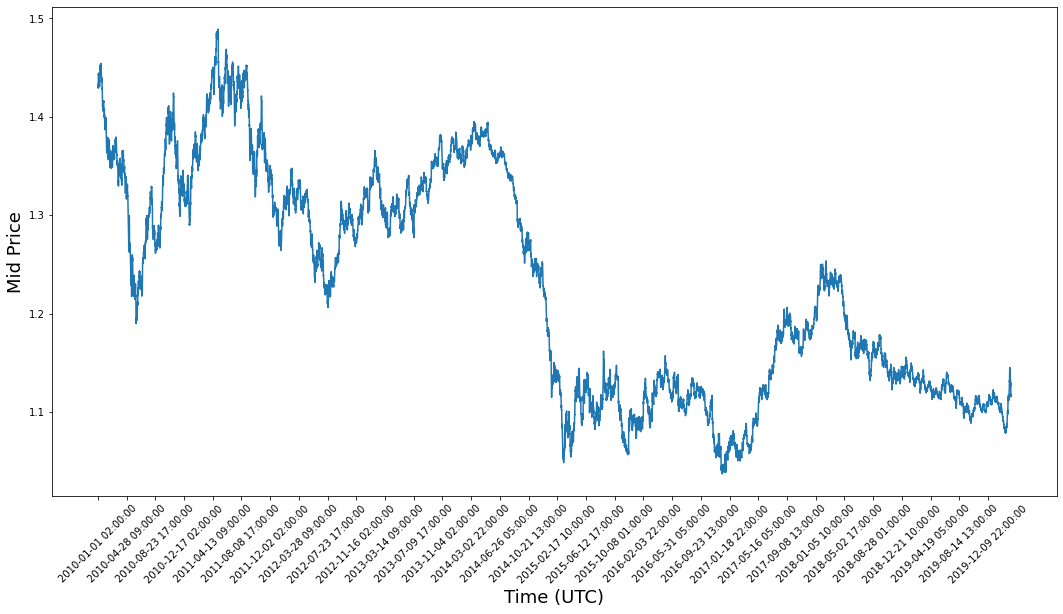

In [17]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Time (UTC)'].loc[::500],rotation=45)
plt.xlabel('Time (UTC)',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [18]:
target = 'mid_price'
cols = ['Time (UTC)','Open',	'High',	'Low'	,'Close','mid_price']


In [21]:
!pip install EMD-signal
#from tqdm import tqdm_notebook
#from pyemd import emd
from PyEMD import EMD
eemd = EMD()

     |████████████████████████████████| 225kB 12.1MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 112kB 20.7MB/s 
     |████████████████████████████████| 133kB 22.1MB/s 
  Created wheel for pathos: filename=pathos-0.2.6-cp36-none-any.whl size=77673 sha256=721f1ec3587571940ed8f533ff9cdc120c2b965f82619f715a8498ff9cb4c4f2
  Stored in directory: /root/.cache/pip/wheels/3a/e8/c8/04cdd0c4bc6fbce35f642fc004244228916daae74bb0f482da
  Created wheel for ppft: filename=ppft-1.6.6.2-cp36-none-any.whl size=64743 sha256=c15d27440d3b2ea1029fdf95cff7f3fac529e4f9648cb786adcb06b20ced827a
  Stored in directory: /root/.cache/pip/wheels/db/d2/2d/0ee21ede61786bb13247dbc69079373fd500c2bb0481913084
  Created wheel for pox: filename=pox-0.2.8-cp36-none-any.whl size=28290 sha256=6b1a6f1176a29bc6e914d2d3cd7bec45b7f9edca9085192a3c4c0e654088d95f
  Stored in directory: /root/.cache/pip/wheels/39/ed/ce/a93103746b327e18bffaeb99ba0d57a88b392f31d719cea700
Successfully

In [22]:
imf = eemd(df[target].values)
imf.shape

(11, 15900)

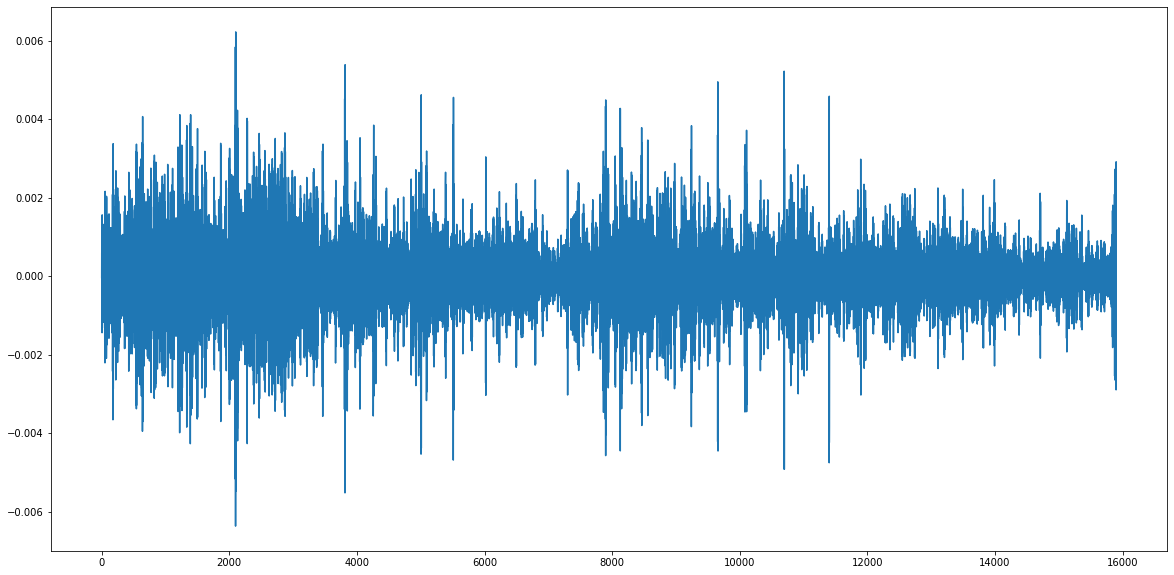

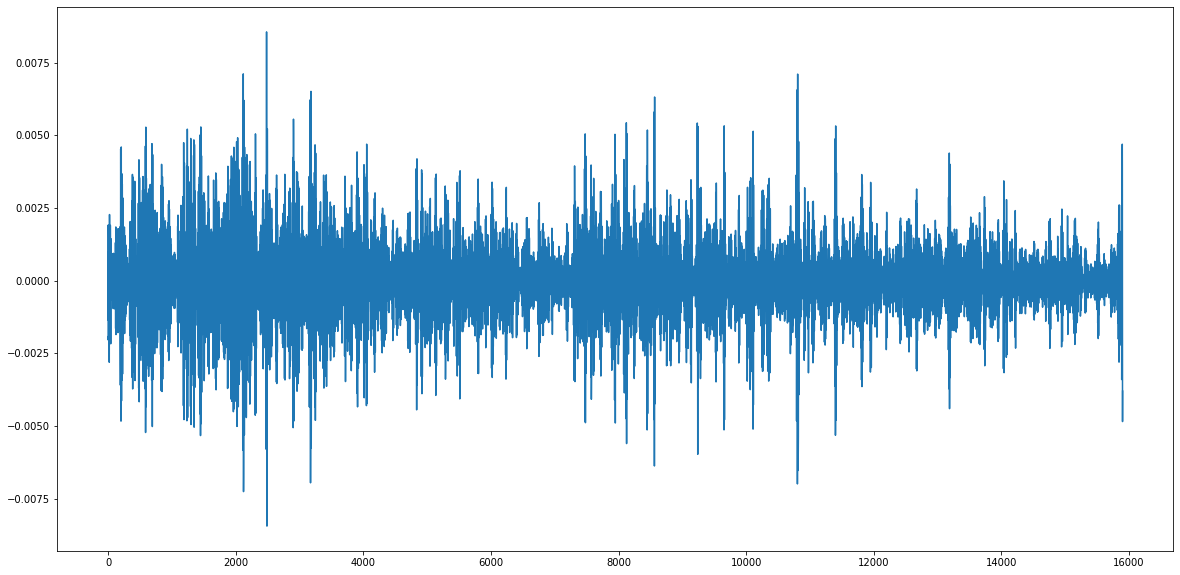

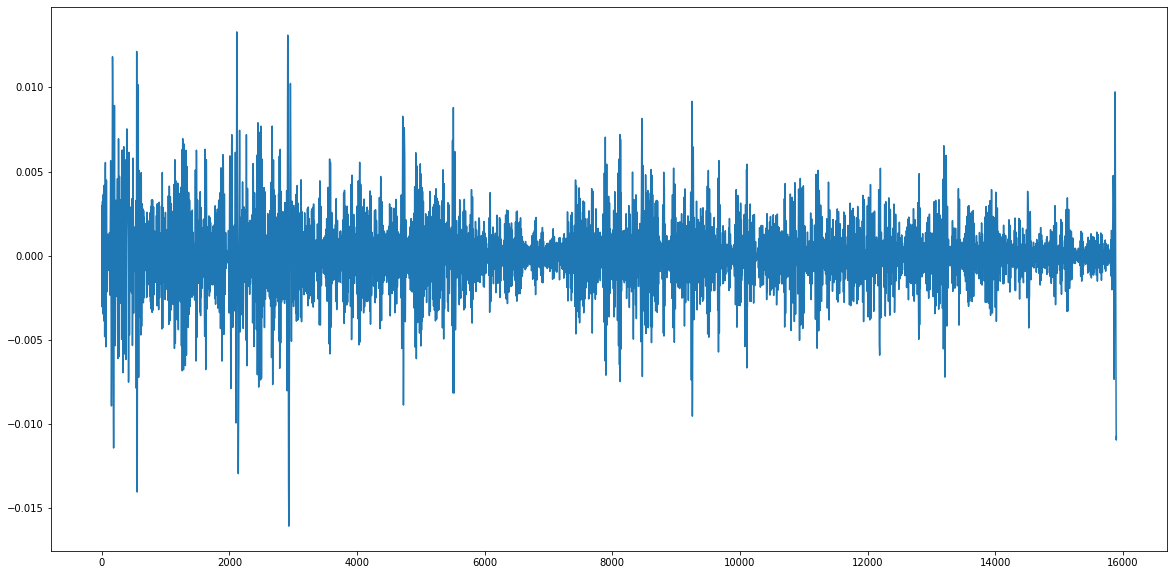

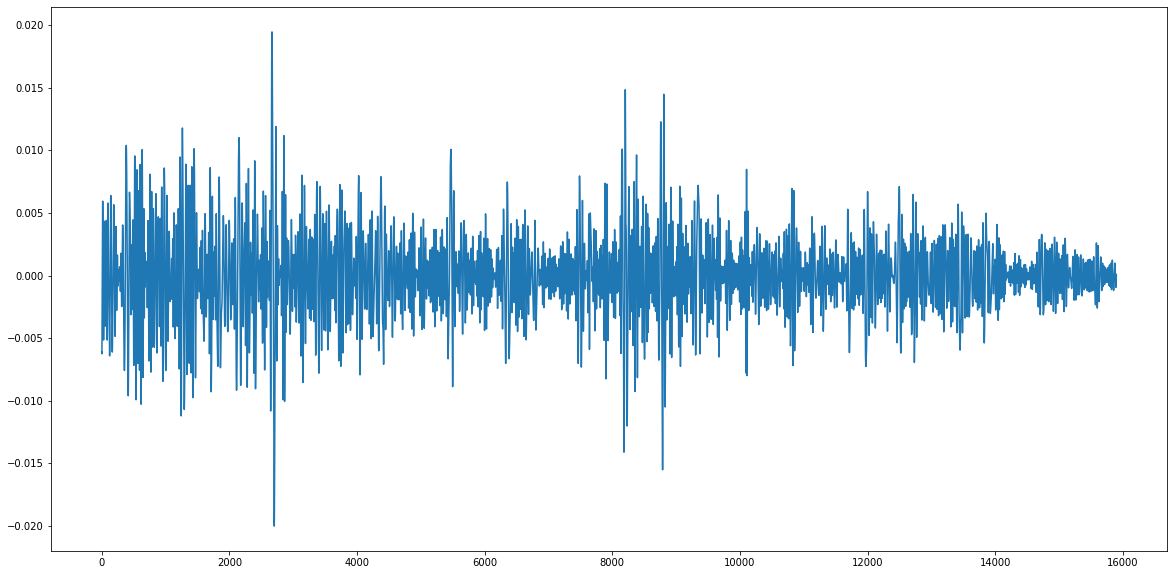

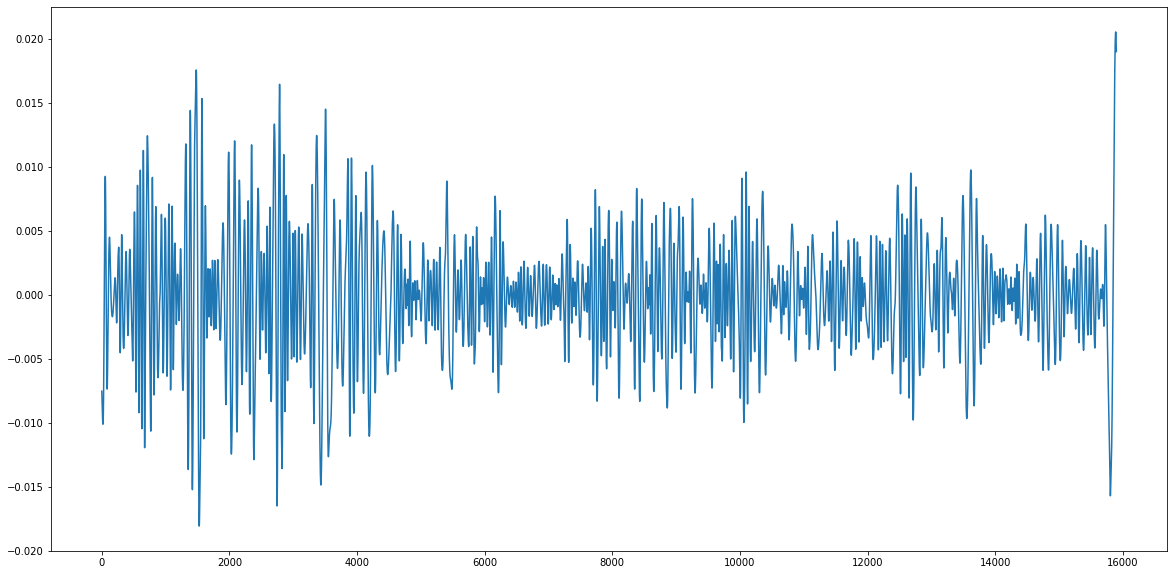

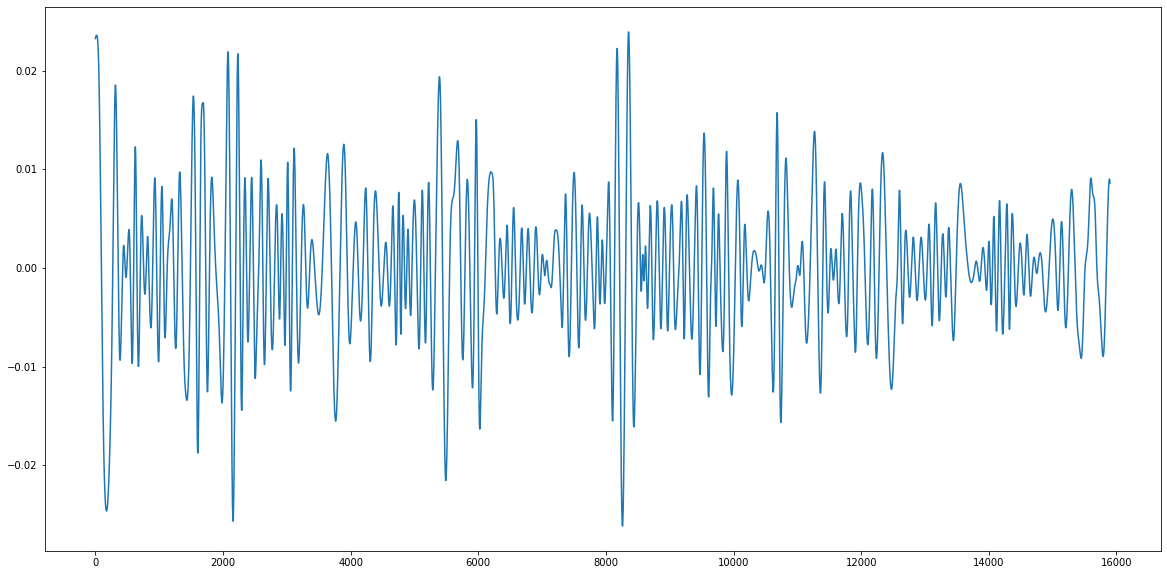

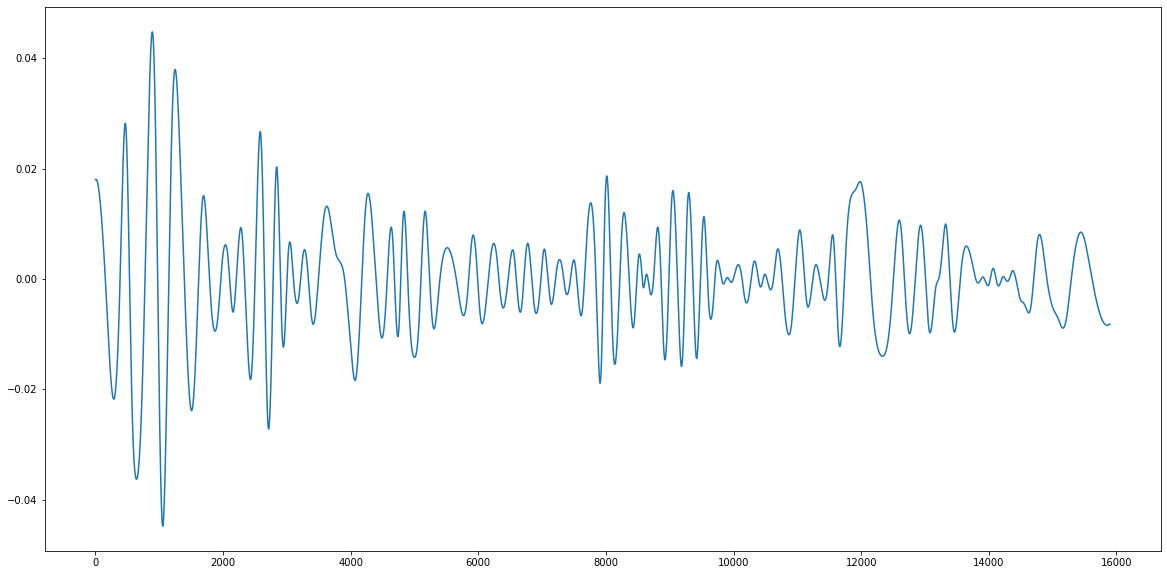

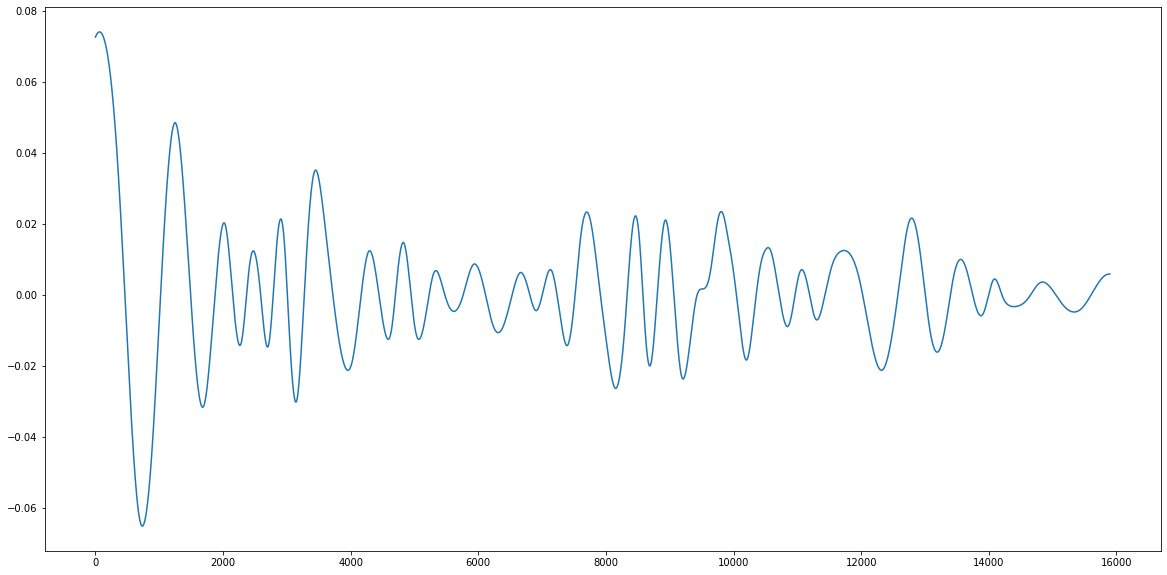

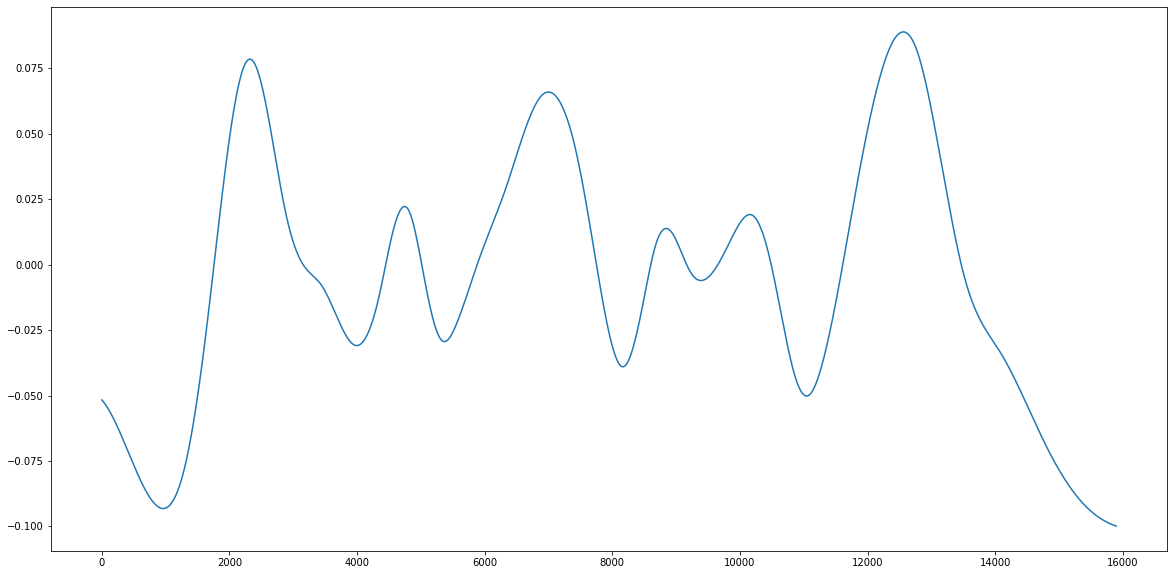

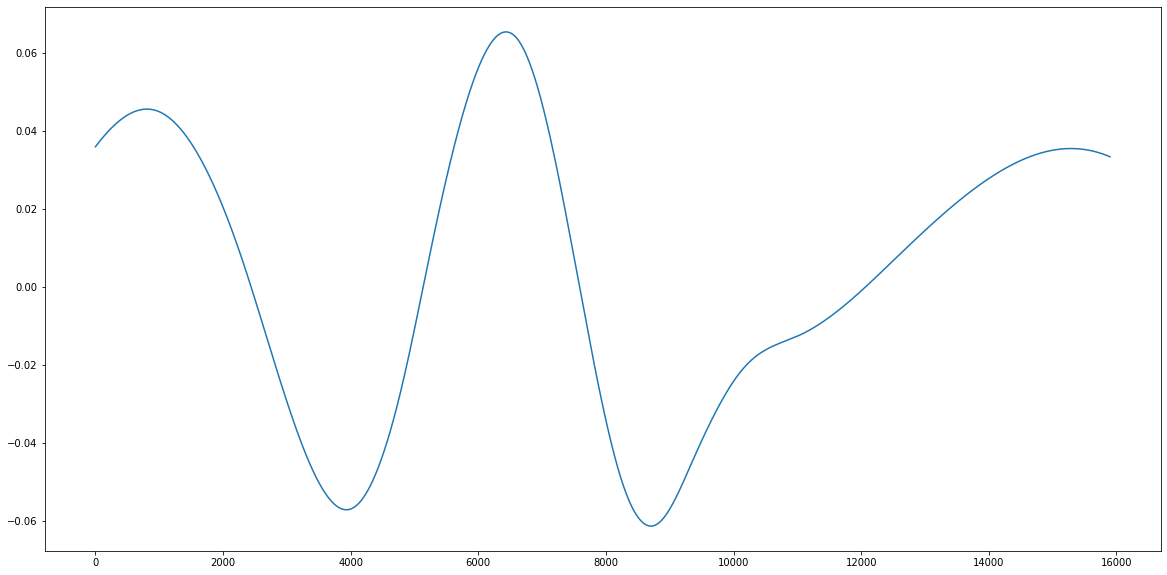

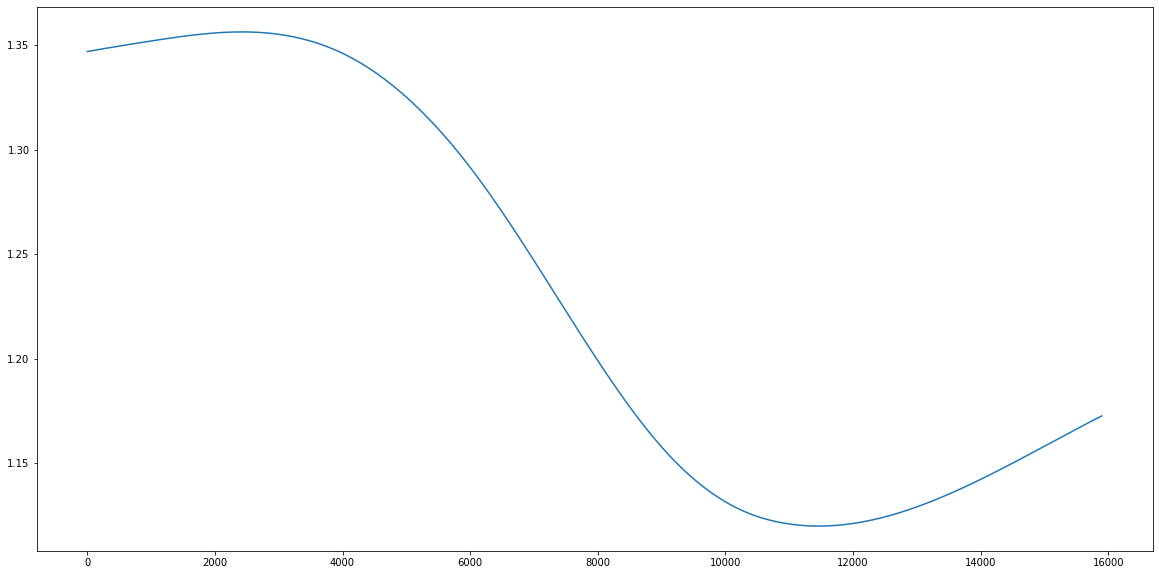

In [23]:
for i in range(11):
    plt.figure(figsize=(20, 10))
    plt.plot(imf[i])
    plt.show()

In [24]:
class SelfBoostedNet(nn.Module):
    def __init__(self, input_dim, aux_outputs, n_conv_channels, conv_kernel_size, n_gru_units):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, n_conv_channels, conv_kernel_size)
        self.conv2 = nn.Conv1d(n_conv_channels, n_conv_channels, conv_kernel_size)
        self.conv3 = nn.Conv1d(n_conv_channels, n_conv_channels, conv_kernel_size)
        self.maxpool = nn.MaxPool1d(2, 2)
        self.gru = nn.GRU(n_conv_channels, n_gru_units, num_layers=2, batch_first=True)
        self.aux_output = nn.Linear(n_gru_units, aux_outputs)
        self.main_output = nn.Linear(n_gru_units, 1)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.maxpool(x)
        x = x.permute(0, 2, 1)
        output, h = self.gru(x)
        main_output = self.main_output(h[-1])
        aux_output = self.aux_output(h[-1])
        return main_output.squeeze(1), aux_output

In [25]:
depth = 20
alpha = 0.1

In [26]:
imf_cols = ['imf_{}'.format(i) for i in range(imf.shape[0])]

In [27]:
for i, name in enumerate(imf_cols):
    df[name] = imf[i]

In [28]:
train_length = int(0.6*len(df))
val_length = int(0.2*len(df))

In [29]:
y = df[target].shift(-1).fillna(method='ffill').values

In [30]:
res = {}
for i in range(1, imf.shape[0]+1):
    print("Step: ", i)
    X = np.zeros((len(df), depth, len(cols) + len(imf_cols[:i])))
    for j, name in enumerate(cols + imf_cols[:i]):
        for k in range(depth):
            X[:, k, j] = df[name].shift(depth - k - 1).fillna(method='bfill')
    y_aux = df[imf_cols[:i]].shift(-1).fillna(method='ffill').values
    
    X_train = X[:train_length]
    X_val = X[train_length:train_length+val_length]
    X_test = X[-val_length:]
    
    y_train = y[:train_length]
    y_val = y[train_length:train_length+val_length]
    y_test = y[-val_length:]
    
    y_aux_train = y_aux[:train_length]
    y_aux_val = y_aux[train_length:train_length+val_length]
    y_aux_test = y_aux[-val_length:]
    
    X_train_min, X_train_max = X_train.min(axis=0), X_train.max(axis=0)
    X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
    X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
    X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)
    
    y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)
    y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
    y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
    y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)
    
    y_aux_train_min, y_aux_train_max = y_aux_train.min(axis=0), y_aux_train.max(axis=0)
    y_aux_train = (y_aux_train - y_aux_train_min)/(y_aux_train_max - y_aux_train_min + 1e-9)
    y_aux_val = (y_aux_val - y_aux_train_min)/(y_aux_train_max - y_aux_train_min + 1e-9)
    y_aux_test = (y_aux_test - y_aux_train_min)/(y_aux_train_max - y_aux_train_min + 1e-9)
    
    X_train_t = torch.Tensor(X_train)
    X_val_t = torch.Tensor(X_val)
    X_test_t = torch.Tensor(X_test)
    
    y_train_t = torch.Tensor(y_train)
    y_val_t = torch.Tensor(y_val)
    y_test_t = torch.Tensor(y_test)
    
    y_aux_train_t = torch.Tensor(y_aux_train)
    y_aux_val_t = torch.Tensor(y_aux_val)
    y_aux_test_t = torch.Tensor(y_aux_test)
    
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t, y_aux_train_t), shuffle=True, batch_size=64)
    val_loader = DataLoader(TensorDataset(X_val_t, y_val_t, y_aux_val_t), shuffle=False, batch_size=64)
    test_loader = DataLoader(TensorDataset(X_test_t, y_test_t, y_aux_test_t), shuffle=False, batch_size=64)
    
    model = SelfBoostedNet(X_train_t.shape[2], i, 32, 3, 32).cuda()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss = nn.MSELoss()
    val_loss = 99999
    for e in range(100):
        train_main_loss, train_aux_loss = 0, 0
        for batch_x, batch_y, batch_y_aux in tqdm(train_loader):
            opt.zero_grad()
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_aux = batch_y_aux.cuda()
            main_output, aux_output = model(batch_x)
            main_loss = loss(main_output, batch_y)
            aux_loss = loss(aux_output, batch_y_aux)
            total_loss = main_loss + alpha*aux_loss
            total_loss.backward()
            opt.step()
            train_main_loss += main_loss.item()*batch_x.shape[0]
            train_aux_loss += aux_loss.item()*batch_x.shape[0]
        with torch.no_grad():
            val_main_loss, val_aux_loss = 0, 0
            for batch_x, batch_y, batch_y_aux in val_loader:
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                batch_y_aux = batch_y_aux.cuda()
                main_output, aux_output = model(batch_x)
                main_loss = loss(main_output, batch_y)
                aux_loss = loss(aux_output, batch_y_aux)
                val_main_loss += main_loss.item()*batch_x.shape[0]
                val_aux_loss += aux_loss.item()*batch_x.shape[0]
            train_main_loss /= X_train_t.shape[0]
            train_aux_loss /= X_train_t.shape[0]
            val_main_loss /= X_val_t.shape[0]
            val_aux_loss /= X_val_t.shape[0]
            if val_loss > val_main_loss:
                val_loss = val_main_loss
                torch.save(model.state_dict(), '/content/drive/My Drive/Assignment_FinGenesis/MD from 2010 to 2020/self_boost_stock_prediction.pt')
            
        print("Iter: ", e,
              "train main loss: ", train_main_loss, 
              "train aux loss: ", train_aux_loss, 
              "val main loss: ", val_main_loss,
              "val aux loss: ", val_aux_loss)
        
    model.load_state_dict(torch.load('/content/drive/My Drive/Assignment_FinGenesis/MD from 2010 to 2020/self_boost_stock_prediction.pt'))
    
    with torch.no_grad():
        val_main_loss, val_aux_loss = 0, 0
        for batch_x, batch_y, batch_y_aux in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_aux = batch_y_aux.cuda()
            main_output, aux_output = model(batch_x)
            main_loss = loss(main_output, batch_y)
            aux_loss = loss(aux_output, batch_y_aux)
            val_main_loss += main_loss.item()*batch_x.shape[0]
            val_aux_loss += aux_loss.item()*batch_x.shape[0]

        test_main_loss, test_aux_loss = 0, 0
        for batch_x, batch_y, batch_y_aux in test_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_aux = batch_y_aux.cuda()
            main_output, aux_output = model(batch_x)
            main_loss = loss(main_output, batch_y)
            aux_loss = loss(aux_output, batch_y_aux)
            test_main_loss += main_loss.item()*batch_x.shape[0]
            test_aux_loss += aux_loss.item()*batch_x.shape[0]
    
    res[i] = (val_main_loss/len(X_val_t), val_aux_loss/len(X_val_t), test_main_loss/len(X_test_t),
              test_aux_loss/len(X_test_t))
    

Step:  1
Step:  2
Step:  3
Step:  4
Step:  5
Step:  6
Step:  7
Step:  8
Step:  9
Step:  10
Step:  11


In [ ]:
val_main_loss = []
val_aux_loss = []
test_main_loss = []
test_aux_loss = []

for k in res.keys():
    val_main_loss.append(res[k][0])
    val_aux_loss.append(res[k][1])
    test_main_loss.append(res[k][2])
    test_aux_loss.append(res[k][3])

NameError: ignored

In [31]:
model.load_state_dict(torch.load("/content/drive/My Drive/Assignment_FinGenesis/MD from 2010 to 2020/self_boost_stock_prediction.pt"))

NameError: ignored

In [ ]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y, batch_y_aux in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        main_output, aux_output = model(batch_x)
        main_output = main_output.squeeze()
        preds.append(main_output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(main_output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

In [ ]:
preds = preds*(y_train_max - y_train_min) + y_train_min
true = true*(y_train_max - y_train_min) + y_train_min

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

In [ ]:
mse, mae

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(preds,label='Predicted price')
plt.plot(true,label='True price')
plt.legend()
plt.show()
